# Regularización Ridge para Predicción de Humedad/Temperatura (_2)
Este notebook implementa un modelo de regresión con regularización Ridge para predecir valores continuos, e incluye curvas de aprendizaje, validación, paridad, sesgo-varianza, validación cruzada y explicaciones breves.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Cargar el dataset
dataset = pd.read_csv('../dataset/ML1_temperature.xlsx - Hoja1.csv', decimal=',')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

In [3]:
# Separar en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Curva de aprendizaje
Muestra cómo varía el error a medida que aumenta el tamaño del conjunto de entrenamiento.

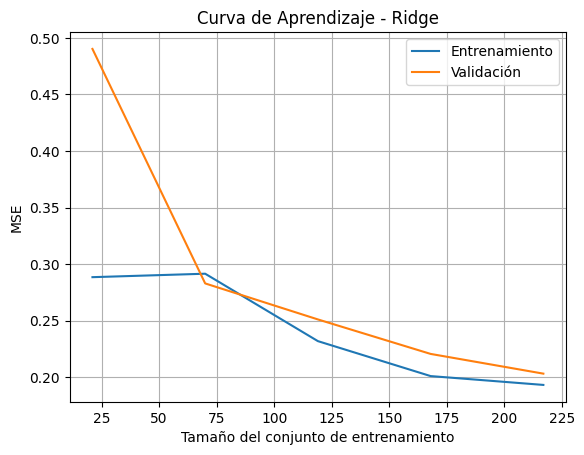

In [4]:
train_sizes, train_scores, val_scores = learning_curve(Ridge(alpha=1.0), x_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error')
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Entrenamiento')
plt.plot(train_sizes, -val_scores.mean(axis=1), label='Validación')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('MSE')
plt.title('Curva de Aprendizaje - Ridge')
plt.legend()
plt.grid(True)
plt.show()

## Curva de validación
Muestra el desempeño del modelo para diferentes valores de alpha (parámetro de regularización).

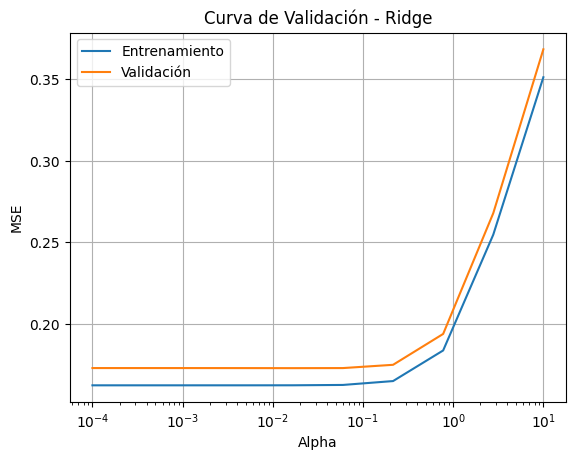

In [5]:
alphas = np.logspace(-4, 1, 10)
train_scores, val_scores = validation_curve(Ridge(), x_train, y_train.ravel(), param_name='alpha', param_range=alphas, cv=5, scoring='neg_mean_squared_error')
plt.semilogx(alphas, -train_scores.mean(axis=1), label='Entrenamiento')
plt.semilogx(alphas, -val_scores.mean(axis=1), label='Validación')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Curva de Validación - Ridge')
plt.legend()
plt.grid(True)
plt.show()

## Curva de paridad
Compara las predicciones del modelo con los valores reales.

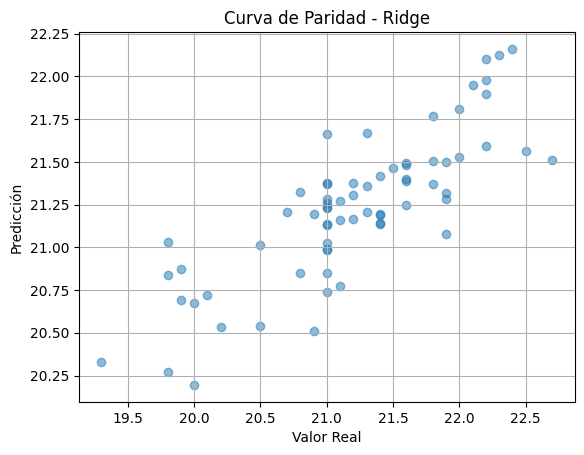

R^2 validación: 0.613


In [ ]:
# Curva de paridad mejorada: Temperatura Real vs Predicha (Entrenamiento y Validación)
plt.figure(figsize=(7,6))
plt.scatter(y_train, model.predict(x_train), alpha=0.7, label='Entrenamiento', color='cornflowerblue')
plt.scatter(y_val, y_val_pred, alpha=0.7, label='Validación', color='darkorange')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Predicción perfecta')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title(f'Temperatura Real vs Predicha\nMSE Validación = {mean_squared_error(y_val, y_val_pred):.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'R^2 validación (Temperatura): {r2_score(y_val, y_val_pred):.3f}')

## Curva de sesgo y varianza
Analiza la diferencia entre el error de entrenamiento y validación.

In [9]:
y_train_pred = model.predict(x_train)
print(f'MSE Entrenamiento: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE Validación: {mean_squared_error(y_val, y_val_pred):.3f}')
print(f'R^2 Entrenamiento: {r2_score(y_train, y_train_pred):.3f}')
print(f'R^2 Validación: {r2_score(y_val, y_val_pred):.3f}')

MSE Entrenamiento: 0.186
MSE Validación: 0.208
R^2 Entrenamiento: 0.622
R^2 Validación: 0.613


## Curva de validación cruzada
Evalúa el desempeño promedio del modelo usando validación cruzada.

In [8]:
cv_scores = cross_val_score(Ridge(alpha=1.0), x, y.ravel(), cv=5, scoring='r2')
print(f'R^2 promedio validación cruzada: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}')

R^2 promedio validación cruzada: -0.091 ± 0.349


## Explicación breve
Ridge es útil para evitar el sobreajuste cuando hay muchas variables correlacionadas. El compromiso sesgo-varianza se ajusta modificando el parámetro alpha.

In [ ]:
# Actual vs Predicho (Entrenamiento y Validación) - Ridge (Temperatura)
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Entrenamiento')
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validación')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title('Actual vs Predicho - Ridge (Temperatura)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Serie temporal: valores reales vs predichos
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Asegúrate de tener y_val y y_val_pred definidos
plt.figure(figsize=(10,4))
plt.plot(range(len(y_val)), y_val, label='Real', color='royalblue', linewidth=2)
plt.plot(range(len(y_val_pred)), y_val_pred, label='Predicho', color='darkorange', linewidth=2)
plt.xlabel('Índice (tiempo)')
plt.ylabel('Variable objetivo')
plt.title(f'Serie temporal: Real vs Predicho (R²={r2_score(y_val, y_val_pred):.3f})')
plt.legend()
plt.tight_layout()
plt.show()